# Wheat Leaf Disease Classification (EfficientNet-B4, Grad-CAM, Logs & Metrics)

Classes:
- BlackPoint
- FusariumFootRot
- HealthyLeaf
- LeafBlight
- WheatBlast

Pipeline:
- Image analysis (counts, sample grid, resolution stats)
- Train/val/test split (reproducible)
- tf.data pipeline + on-the-fly Keras augmentations (no tensorflow_addons)
- EfficientNet-B4 classifier (Adam, dropout, L2)
- Callbacks: ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
- Metrics: classification report + confusion matrix
- Grad-CAM visualizations
- Single-image prediction helper (optionally with Grad-CAM)

> Install (once):  
> `pip install tensorflow>=2.16 pillow opencv-python scikit-learn matplotlib`


# Config & Setup

In [1]:
# =========================
# ======== CONFIG =========
# =========================
import os, sys, json, time, math, logging, random, shutil
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix

# ----- Logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(asctime)s - %(message)s')
log = logging.getLogger("wheat-pipeline")

# ----- Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ====== EDIT THIS PATH to point to folder that contains the 5 class subfolders ======
DATASET_DIR = Path("/Users/soumyajitbera/Documents/GitHub/data/Wheat_augmented")   # e.g., /path/to/wheat with subfolders per class

# ----- Work/output directories
WORK_DIR = Path("./wheat_workdir")
SPLIT_DIR = WORK_DIR / "split"
MODEL_DIR = WORK_DIR / "models"
CKPT_DIR  = MODEL_DIR / "checkpoints"
LOGS_DIR  = WORK_DIR / "logs"
TB_DIR    = LOGS_DIR / "tensorboard"
GRADCAM_DIR = WORK_DIR / "gradcam_samples"

for p in [WORK_DIR, SPLIT_DIR, MODEL_DIR, CKPT_DIR, LOGS_DIR, TB_DIR, GRADCAM_DIR]:
    p.mkdir(parents=True, exist_ok=True)

CSV_LOG = LOGS_DIR / "training_logs.csv"
HISTORY_JSON = WORK_DIR / "history.json"

# ----- Classes (from your folders)
CLASS_NAMES = ["BlackPoint", "FusariumFootRot", "HealthyLeaf", "LeafBlight", "WheatBlast"]
NUM_CLASSES = len(CLASS_NAMES)

# ----- Model/Training hyperparameters
IMAGE_SIZE   = 380
BATCH_SIZE   = 16
EPOCHS       = 30
LEARNING_RATE= 5e-4
DROPOUT      = 0.30
L2_REG       = 1e-4
PATIENCE     = 6

# ----- Augmentations (Keras built-ins)
AUG_CFG = dict(
    flip=True,
    rotate=0.05,     # ~5%
    zoom=0.10,
    contrast=0.10,
    brightness=0.05
)

# ----- Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

log.info("TensorFlow: %s", tf.__version__)
log.info("Dataset dir: %s", DATASET_DIR.resolve())
log.info("Work dir: %s", WORK_DIR.resolve())


[INFO] 2025-10-25 11:30:59,929 - TensorFlow: 2.20.0
[INFO] 2025-10-25 11:30:59,930 - Dataset dir: /Users/soumyajitbera/Documents/GitHub/data/Wheat_augmented
[INFO] 2025-10-25 11:30:59,930 - Work dir: /Users/soumyajitbera/Documents/GitHub/AgroAI/wheat_workdir


# Image Analysis (counts, sample grid, resolution stats)

In [2]:
from PIL import Image
from collections import Counter

def count_images_by_class(root: Path, class_names: List[str]) -> Dict[str, int]:
    counts = {}
    for c in class_names:
        folder = root / c
        if not folder.exists():
            log.warning("Class folder missing: %s", folder)
            counts[c] = 0
            continue
        files = []
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
            files += list(folder.rglob(ext))
        counts[c] = len(files)
    return counts

def sample_grid(root: Path, class_names: List[str], n_per_class: int = 4, size: int = 160):
    imgs, labels = [], []
    for c in class_names:
        folder = root / c
        paths = []
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp"]:
            paths += list(folder.rglob(ext))
        random.shuffle(paths)
        for p in paths[:n_per_class]:
            try:
                imgs.append(Image.open(p).convert("RGB").resize((size, size)))
                labels.append(c)
            except Exception as e:
                log.warning("Failed to open %s: %s", p, e)
    cols = n_per_class
    rows = len(class_names)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i,(im,lab) in enumerate(zip(imgs,labels)):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(im)
        plt.title(lab, fontsize=8)
        plt.axis("off")
    plt.tight_layout(); plt.show()

def resolution_stats(root: Path, class_names: List[str], max_per_class: int = 300):
    widths, heights = [], []
    for c in class_names:
        folder = root / c
        paths = []
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp"]:
            paths += list(folder.rglob(ext))
        random.shuffle(paths)
        for p in paths[:max_per_class]:
            try:
                with Image.open(p) as im:
                    w, h = im.size
                    widths.append(w); heights.append(h)
            except Exception as e:
                log.warning("Failed to read %s: %s", p, e)
    if widths and heights:
        log.info("Resolution stats — width: mean=%.1f | median=%d | min=%d | max=%d",
                 float(np.mean(widths)), int(np.median(widths)), int(np.min(widths)), int(np.max(widths)))
        log.info("Resolution stats — height: mean=%.1f | median=%d | min=%d | max=%d",
                 float(np.mean(heights)), int(np.median(heights)), int(np.min(heights)), int(np.max(heights)))
        plt.figure(figsize=(6,3)); plt.hist(widths, bins=30);  plt.title("Width distribution");  plt.show()
        plt.figure(figsize=(6,3)); plt.hist(heights, bins=30); plt.title("Height distribution"); plt.show()

counts = count_images_by_class(DATASET_DIR, CLASS_NAMES)
log.info("Image counts per class: %s", counts)

# Optional previews:
# sample_grid(DATASET_DIR, CLASS_NAMES, n_per_class=4, size=160)
# resolution_stats(DATASET_DIR, CLASS_NAMES, max_per_class=300)


[INFO] 2025-10-25 11:31:27,998 - Image counts per class: {'BlackPoint': 1053, 'FusariumFootRot': 1187, 'HealthyLeaf': 1142, 'LeafBlight': 917, 'WheatBlast': 1398}


# Train/Val/Test Split (reproducible)

In [3]:
def safe_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)

def make_split(dataset_dir: Path, split_dir: Path, class_names: List[str],
               train_ratio: float, val_ratio: float, test_ratio: float, seed: int = 42):
    random.seed(seed)
    # Clear existing split
    if split_dir.exists():
        for sub in ["train","val","test"]:
            p = split_dir / sub
            if p.exists(): shutil.rmtree(p)
            p.mkdir(parents=True, exist_ok=True)

    for c in class_names:
        paths = []
        for ext in ["*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp"]:
            paths += list((dataset_dir / c).rglob(ext))
        random.shuffle(paths)
        n = len(paths)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        train_paths = paths[:n_train]
        val_paths   = paths[n_train:n_train+n_val]
        test_paths  = paths[n_train+n_val:]

        for p in train_paths: safe_copy(p, split_dir / "train" / c / p.name)
        for p in val_paths:   safe_copy(p, split_dir / "val"   / c / p.name)
        for p in test_paths:  safe_copy(p, split_dir / "test"  / c / p.name)
        log.info("%s -> train=%d, val=%d, test=%d", c, len(train_paths), len(val_paths), len(test_paths))

make_split(DATASET_DIR, SPLIT_DIR, CLASS_NAMES, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=SEED)


[INFO] 2025-10-25 12:15:10,046 - BlackPoint -> train=737, val=157, test=159
[INFO] 2025-10-25 12:15:11,299 - FusariumFootRot -> train=830, val=178, test=179
[INFO] 2025-10-25 12:15:12,238 - HealthyLeaf -> train=799, val=171, test=172
[INFO] 2025-10-25 12:15:12,988 - LeafBlight -> train=641, val=137, test=139
[INFO] 2025-10-25 12:15:14,717 - WheatBlast -> train=978, val=209, test=211


# tf.data Pipeline with Augmentations

In [5]:
def make_augmenter():
    ops = []
    if AUG_CFG.get("flip", False): ops.append(layers.RandomFlip("horizontal"))
    r = float(AUG_CFG.get("rotate", 0.0))   
    if r > 0: 
        ops.append(layers.RandomRotation(r))
    z = float(AUG_CFG.get("zoom", 0.0))
    if z > 0: 
        ops.append(layers.RandomZoom(z))
    c = float(AUG_CFG.get("contrast", 0.0))
    if c > 0: 
        ops.append(layers.RandomContrast(c))
    b = float(AUG_CFG.get("brightness", 0.0))
    if b > 0: 
        ops.append(layers.RandomBrightness(b))
    return keras.Sequential(ops, name="augmenter")

def make_datasets(split_dir: Path, image_size: int, batch_size: int):
    train = keras.utils.image_dataset_from_directory(
        split_dir / "train", labels="inferred", label_mode="int",
        image_size=(image_size, image_size), batch_size=batch_size, shuffle=True, seed=SEED)
    val = keras.utils.image_dataset_from_directory(
        split_dir / "val", labels="inferred", label_mode="int",
        image_size=(image_size, image_size), batch_size=batch_size, shuffle=False, seed=SEED)
    test = keras.utils.image_dataset_from_directory(
        split_dir / "test", labels="inferred", label_mode="int",
        image_size=(image_size, image_size), batch_size=batch_size, shuffle=False, seed=SEED)

    preprocess = tf.keras.applications.efficientnet.preprocess_input
    aug = make_augmenter()
    autotune = tf.data.AUTOTUNE

    train = train.map(lambda x,y: (preprocess(aug(x)), y), num_parallel_calls=autotune).prefetch(autotune)
    val   = val.map(  lambda x,y: (preprocess(x), y),     num_parallel_calls=autotune).prefetch(autotune)
    test  = test.map(  lambda x,y: (preprocess(x), y),    num_parallel_calls=autotune).prefetch(autotune)
    return train, val, test

train_ds, val_ds, test_ds = make_datasets(SPLIT_DIR, IMAGE_SIZE, BATCH_SIZE)
log.info("Datasets ready: train=%s, val=%s, test=%s", train_ds, val_ds, test_ds)


Found 3985 files belonging to 5 classes.
Found 852 files belonging to 5 classes.
Found 860 files belonging to 5 classes.


[INFO] 2025-10-25 12:18:41,026 - Datasets ready: train=<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, val=<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, test=<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 380, 380, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Build EfficientNet-B4 Model

In [6]:
from tensorflow.keras import regularizers

def build_model(input_shape: Tuple[int,int,int], num_classes: int):
    base = tf.keras.applications.efficientnet.EfficientNetB4(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(DROPOUT)(x)
    outputs = layers.Dense(
        num_classes, activation="softmax",
        kernel_regularizer=regularizers.l2(L2_REG)
    )(x)

    model = keras.Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model((IMAGE_SIZE, IMAGE_SIZE, 3), NUM_CLASSES)
model.summary()


Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb4_notop.h5: None -- [Errno 8] nodename nor servname provided, or not known

In [1]:
# Imports & config (mirrors rice notebook)
import os, sys, json, math, shutil, logging, random
from glob import glob
from collections import Counter
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

# ---- Logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(asctime)s - %(message)s')
log = logging.getLogger("wheat-cnn")

# ---- Reproducibility
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ====== PATHS ======
# RAW data: point this to the folder that contains the 5 class subfolders
RAW_DATA_DIR = "/Users/soumyajitbera/Documents/GitHub/data/Wheat_augmented"          # e.g., ./data/wheat_raw/BlackPoint, ...
PROC_DATA_DIR = "data/wheat_processed"   # optional, if you run preprocessing step below
USE_PROCESSED = False                     # set True after you run preprocessing once

DATA_DIR = PROC_DATA_DIR if USE_PROCESSED else RAW_DATA_DIR

OUT_DIR = "outputs_wheat"
os.makedirs(OUT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(OUT_DIR, "wheat_cnn_best.keras")   # best checkpoint (Keras v3)
CLASS_MAP_JSON = os.path.join(OUT_DIR, "class_indices.json")
HISTORY_CSV = os.path.join(OUT_DIR, "history.csv")
CONF_MAT_PNG = os.path.join(OUT_DIR, "confusion_matrix.png")
REPORT_TXT = os.path.join(OUT_DIR, "classification_report.txt")

# ---- Model & training hyperparams (same pattern as rice)
IMG_SIZE = (224, 224)     # custom CNN used 224x224
BATCH_SIZE = 32
EPOCHS = 40
VAL_SPLIT = 0.18
TEST_SPLIT = 0.12         # overall ≈ 70/18/12

# ---- Class names (your wheat set)
# Make sure these exactly match the folder names in DATA_DIR
class_names = ["BlackPoint", "FusariumFootRot", "HealthyLeaf", "LeafBlight", "WheatBlast"]

log.info(f"TensorFlow: {tf.__version__}")
log.info(f"DATA_DIR: {DATA_DIR}  | OUT_DIR: {OUT_DIR}")


[INFO] 2025-11-01 21:44:43,270 - TensorFlow: 2.20.0
[INFO] 2025-11-01 21:44:43,271 - DATA_DIR: /Users/soumyajitbera/Documents/GitHub/data/Wheat_augmented  | OUT_DIR: outputs_wheat


In [2]:
# Optional preprocessing to build a processed dataset (run once, then set USE_PROCESSED=True)
import cv2
import numpy as np
import os

def leaf_crop_and_fix(img_bgr, pad=8):
    """Quick leaf crop via HSV green mask + CLAHE on L channel."""
    h, w = img_bgr.shape[:2]
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (25, 20, 20), (95, 255, 255))  # broad green
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, 2)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    crop = img_bgr
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        x,y,wc,hc = cv2.boundingRect(c)
        x0 = max(x-pad, 0); y0 = max(y-pad, 0)
        x1 = min(x+wc+pad, w); y1 = min(y+hc+pad, h)
        crop = img_bgr[y0:y1, x0:x1]

    lab = cv2.cvtColor(crop, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2,a,b])
    out = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    return out

def build_processed_dataset(src_root, dst_root):
    if os.path.exists(dst_root):
        shutil.rmtree(dst_root)
    ok, total = 0, 0
    for cls in class_names:
        sdir = os.path.join(src_root, cls)
        ddir = os.path.join(dst_root, cls)
        os.makedirs(ddir, exist_ok=True)
        for p in glob(os.path.join(sdir, "*")):
            if not os.path.isfile(p): continue
            total += 1
            img = cv2.imread(p)
            if img is None:
                log.warning(f"Unreadable: {p}"); continue
            fixed = leaf_crop_and_fix(img)
            cv2.imwrite(os.path.join(ddir, os.path.basename(p)), fixed)
            ok += 1
    log.info(f"Processed {ok}/{total} images -> {dst_root}")

# Run once if you want processed set, then set USE_PROCESSED=True (above):
# build_processed_dataset(RAW_DATA_DIR, PROC_DATA_DIR)


In [3]:
def scan_images(root):
    # keep order from class_names to ensure label mapping consistency
    files, labels = [], []
    for idx, cls in enumerate(class_names):
        cdir = os.path.join(root, cls)
        for p in glob(os.path.join(cdir, "*")):
            if os.path.isfile(p):
                files.append(p)
                labels.append(idx)
    return np.array(files), np.array(labels)

X_all, y_all = scan_images(DATA_DIR)
log.info(f"Classes: {class_names}; total images: {len(X_all)}")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SPLIT, random_state=SEED, stratify=y_all
)
val_size_adj = VAL_SPLIT / (1.0 - TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_adj, random_state=SEED, stratify=y_trainval
)

with open(CLASS_MAP_JSON, "w") as f:
    json.dump({name: i for i, name in enumerate(class_names)}, f, indent=2)
log.info(f"Saved class map -> {CLASS_MAP_JSON}")
log.info(f"Split sizes -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


[INFO] 2025-11-01 21:45:13,091 - Classes: ['BlackPoint', 'FusariumFootRot', 'HealthyLeaf', 'LeafBlight', 'WheatBlast']; total images: 5697
[INFO] 2025-11-01 21:45:13,097 - Saved class map -> outputs_wheat/class_indices.json
[INFO] 2025-11-01 21:45:13,097 - Split sizes -> train: 3987, val: 1026, test: 684


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.20),
], name="aug")

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)     # [0,1]
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return img

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _load(p, y):
        img = decode_img(p)
        if training:
            img = data_augmentation(img)
        y1 = tf.one_hot(y, depth=len(class_names))
        return img, y1
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)


In [5]:
def conv_block(x, filters, k=3, pool=True):
    x = layers.Conv2D(filters, k, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pool: 
        x = layers.MaxPooling2D()(x)
    return x

def build_cnn(input_shape=(224,224,3), num_classes=5, dropout=0.5):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 32)          # 224->112
    x = conv_block(x, 64)               # 112->56
    x = conv_block(x, 128)              # 56->28
    x = conv_block(x, 192)              # 28->14
    x = conv_block(x, 256, pool=False)  # keep detail at 14x14
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="WheatCNN")

model = build_cnn(input_shape=(*IMG_SIZE,3), num_classes=len(class_names), dropout=0.5)
model.summary()

loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
opt  = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])


Model: "WheatCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 192)    │       221,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       442,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 792,805 (3.02 MB)

 Trainable params: 791,461 (3.02 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [6]:
classes_unique = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes_unique, y=y_train)
class_weight = dict(zip(classes_unique.tolist(), weights.tolist()))
log.info(f"class_weight: {class_weight}")

csv_logger = keras.callbacks.CSVLogger(HISTORY_CSV, append=False)
ckpt   = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor="val_accuracy",
                                         save_best_only=True, verbose=1)
early  = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
plateau= keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)

log.info("Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[csv_logger, ckpt, early, plateau],
    verbose=1
)
log.info(f"Training done. Best model stored at -> {MODEL_PATH}")


[INFO] 2025-11-01 21:45:54,826 - class_weight: {0: 1.0819538670284938, 1: 0.9595667870036101, 2: 0.9979974968710889, 3: 1.2420560747663552, 4: 0.8153374233128834}
[INFO] 2025-11-01 21:45:54,828 - Starting training...


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5905 - loss: 1.1565
Epoch 1: val_accuracy improved from None to 0.18616, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7181 - loss: 0.8823 - val_accuracy: 0.1862 - val_loss: 3.4210 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8552 - loss: 0.6029
Epoch 2: val_accuracy improved from 0.18616 to 0.34795, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8768 - loss: 0.5665 - val_accuracy: 0.3480 - val_loss: 2.6961 - learning_rate: 0.0010
Epoch 3/40


2025-11-01 21:51:21.662339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1899 of 2048
2025-11-01 21:51:22.437617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8940 - loss: 0.5351
Epoch 3: val_accuracy improved from 0.34795 to 0.48246, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9074 - loss: 0.5049 - val_accuracy: 0.4825 - val_loss: 1.9834 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9122 - loss: 0.4905
Epoch 4: val_accuracy improved from 0.48246 to 0.70078, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9215 - loss: 0.4743 - val_accuracy: 0.7008 - val_loss: 1.3023 - learning_rate: 0.0010
Epoch 5/40


2025-11-01 21:57:40.209592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1438 of 2048
2025-11-01 21:57:44.236297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9140 - loss: 0.4742
Epoch 5: val_accuracy did not improve from 0.70078
125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9235 - loss: 0.4701 - val_accuracy: 0.6296 - val_loss: 1.4352 - learning_rate: 0.0010
Epoch 6/40


2025-11-01 22:01:24.208102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1668 of 2048
2025-11-01 22:01:26.461352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9397 - loss: 0.4332
Epoch 6: val_accuracy improved from 0.70078 to 0.90253, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9398 - loss: 0.4324 - val_accuracy: 0.9025 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 7/40


2025-11-01 22:05:03.394223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1627 of 2048
2025-11-01 22:05:05.942193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9456 - loss: 0.4212
Epoch 7: val_accuracy improved from 0.90253 to 0.93275, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9463 - loss: 0.4111 - val_accuracy: 0.9327 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 8/40


2025-11-01 22:08:35.288199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1663 of 2048
2025-11-01 22:08:37.612079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9376 - loss: 0.4147
Epoch 8: val_accuracy did not improve from 0.93275
125/125 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.9403 - loss: 0.4151 - val_accuracy: 0.8538 - val_loss: 0.6066 - learning_rate: 0.0010
Epoch 9/40


2025-11-01 22:12:11.484993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1652 of 2048
2025-11-01 22:12:13.901017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9484 - loss: 0.4074
Epoch 9: val_accuracy did not improve from 0.93275
125/125 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.9531 - loss: 0.3975 - val_accuracy: 0.9220 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 10/40


2025-11-01 22:19:06.229524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1245 of 2048
2025-11-01 22:19:15.832578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9583 - loss: 0.3849 
Epoch 10: val_accuracy improved from 0.93275 to 0.97856, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1743s 14s/step - accuracy: 0.9601 - loss: 0.3810 - val_accuracy: 0.9786 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 11/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9659 - loss: 0.3657
Epoch 11: val_accuracy did not improve from 0.97856
125/125 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.9651 - loss: 0.3693 - val_accuracy: 0.9308 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 12/40


2025-11-01 22:55:20.685965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1423 of 2048
2025-11-01 22:55:23.840706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9601 - loss: 0.3787 
Epoch 12: val_accuracy did not improve from 0.97856
125/125 ━━━━━━━━━━━━━━━━━━━━ 2562s 13s/step - accuracy: 0.9624 - loss: 0.3744 - val_accuracy: 0.9435 - val_loss: 0.3851 - learning_rate: 0.0010
Epoch 13/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9681 - loss: 0.3627 
Epoch 13: val_accuracy did not improve from 0.97856

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1968s 16s/step - accuracy: 0.9646 - loss: 0.3717 - val_accuracy: 0.7719 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 14/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9754 - loss: 0.3422 
Epoch 14: val_accuracy did not improve from 0.97856
125/125 ━━━━━━━━━━━━━━━━━━━━ 1651s 13s/step - accuracy: 0.9812 - loss: 0.3298 - val_accuracy: 0.9756 - val_loss: 0.3315 - learning_rate: 3.0000e-04
Epoch 15/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9807 - lo

2025-11-02 06:20:32.429907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1775 of 2048
2025-11-02 06:20:34.100450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9918 - loss: 0.2981 
Epoch 25: val_accuracy did not improve from 0.99220
125/125 ━━━━━━━━━━━━━━━━━━━━ 2590s 13s/step - accuracy: 0.9917 - loss: 0.2972 - val_accuracy: 0.9883 - val_loss: 0.2761 - learning_rate: 3.0000e-04
Epoch 26/40


2025-11-02 06:48:22.820314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1926 of 2048
2025-11-02 06:48:23.415663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9903 - loss: 0.2956 
Epoch 26: val_accuracy did not improve from 0.99220
125/125 ━━━━━━━━━━━━━━━━━━━━ 2633s 21s/step - accuracy: 0.9887 - loss: 0.2981 - val_accuracy: 0.9903 - val_loss: 0.2838 - learning_rate: 3.0000e-04
Epoch 27/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9896 - loss: 0.2953
Epoch 27: val_accuracy did not improve from 0.99220

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1138s 9s/step - accuracy: 0.9900 - loss: 0.2956 - val_accuracy: 0.9873 - val_loss: 0.2907 - learning_rate: 3.0000e-04
Epoch 28/40


2025-11-02 07:52:21.675161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 873 of 2048
2025-11-02 07:52:27.329181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9938 - loss: 0.2886
Epoch 28: val_accuracy improved from 0.99220 to 0.99318, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 595s 4s/step - accuracy: 0.9930 - loss: 0.2889 - val_accuracy: 0.9932 - val_loss: 0.2585 - learning_rate: 9.0000e-05
Epoch 29/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9909 - loss: 0.2880
Epoch 29: val_accuracy did not improve from 0.99318
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9927 - loss: 0.2860 - val_accuracy: 0.9893 - val_loss: 0.2834 - learning_rate: 9.0000e-05
Epoch 30/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9935 - loss: 0.2880
Epoch 30: val_accuracy improved from 0.99318 to 0.99415, saving model to outputs_wheat/wheat_cnn_best.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9945 - loss: 0.2831 - val_accuracy: 0.9942 - val_loss: 0.2690 - learning_rate: 9.0000e-05
Epoch 31/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1

2025-11-02 08:34:08.964471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1765 of 2048
2025-11-02 08:34:10.428825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9950 - loss: 0.2818 
Epoch 33: val_accuracy did not improve from 0.99415
125/125 ━━━━━━━━━━━━━━━━━━━━ 1607s 13s/step - accuracy: 0.9952 - loss: 0.2804 - val_accuracy: 0.9912 - val_loss: 0.2653 - learning_rate: 2.7000e-05
Epoch 34/40


2025-11-02 09:16:13.418917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 943 of 2048
2025-11-02 09:16:18.476121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9968 - loss: 0.2787
Epoch 34: val_accuracy did not improve from 0.99415

Epoch 34: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
125/125 ━━━━━━━━━━━━━━━━━━━━ 2135s 10s/step - accuracy: 0.9950 - loss: 0.2795 - val_accuracy: 0.9922 - val_loss: 0.2795 - learning_rate: 2.7000e-05
Epoch 35/40


2025-11-02 09:46:41.792364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 615 of 2048
2025-11-02 09:46:47.672850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9962 - loss: 0.2791
Epoch 35: val_accuracy did not improve from 0.99415
125/125 ━━━━━━━━━━━━━━━━━━━━ 2468s 15s/step - accuracy: 0.9967 - loss: 0.2773 - val_accuracy: 0.9922 - val_loss: 0.2686 - learning_rate: 8.1000e-06


[INFO] 2025-11-02 10:17:28,294 - Training done. Best model stored at -> outputs_wheat/wheat_cnn_best.keras


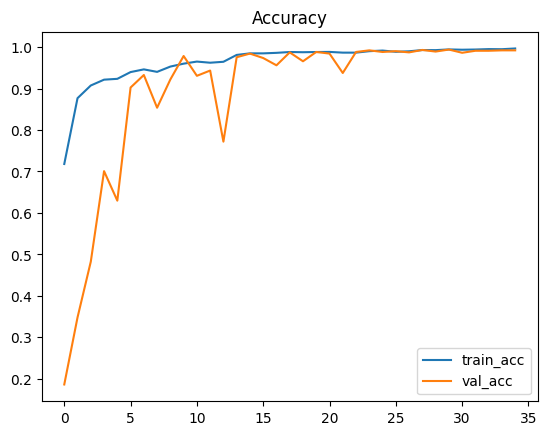

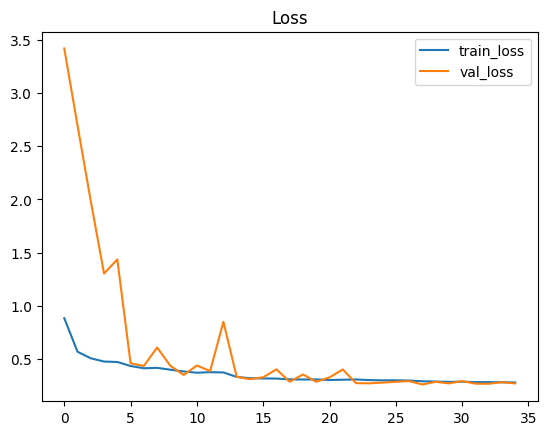

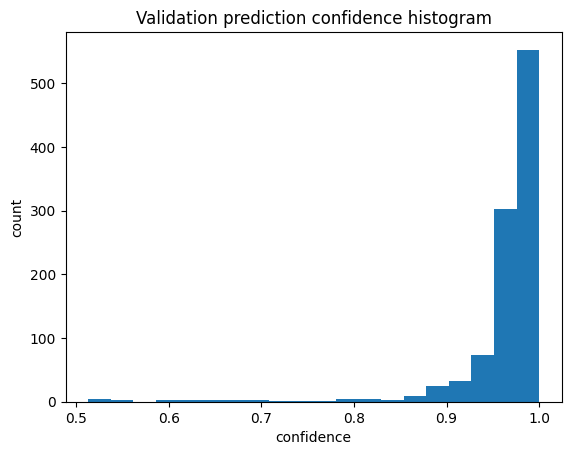

In [7]:
def plot_curves(h):
    plt.figure(); plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.show()

    plt.figure(); plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()

plot_curves(history)

# confidence histogram on validation
y_val_probs = model.predict(val_ds, verbose=0)
conf = np.max(y_val_probs, axis=1)
plt.figure(); plt.hist(conf, bins=20)
plt.title("Validation prediction confidence histogram")
plt.xlabel("confidence"); plt.ylabel("count"); plt.show()


[INFO] 2025-11-02 11:14:57,055 - TEST — loss: 0.2698, acc: 0.9898
2025-11-02 11:15:03.411033: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


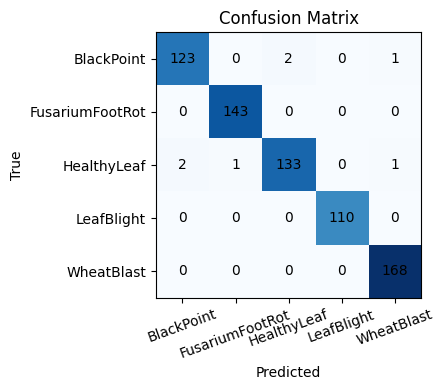

[INFO] 2025-11-02 11:15:03,487 - Saved confusion matrix -> outputs_wheat/confusion_matrix.png
[INFO] 2025-11-02 11:15:03,491 - Saved report -> outputs_wheat/classification_report.txt


                 precision    recall  f1-score   support

     BlackPoint     0.9840    0.9762    0.9801       126
FusariumFootRot     0.9931    1.0000    0.9965       143
    HealthyLeaf     0.9852    0.9708    0.9779       137
     LeafBlight     1.0000    1.0000    1.0000       110
     WheatBlast     0.9882    1.0000    0.9941       168

       accuracy                         0.9898       684
      macro avg     0.9901    0.9894    0.9897       684
   weighted avg     0.9897    0.9898    0.9897       684



In [8]:
best_model = keras.models.load_model(MODEL_PATH)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
log.info(f"TEST — loss: {test_loss:.4f}, acc: {test_acc:.4f}")

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = best_model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(labs.numpy(), axis=1))
y_true, y_pred = np.array(y_true), np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix")
plt.xticks(range(len(class_names)), class_names, rotation=20)
plt.yticks(range(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.savefig(CONF_MAT_PNG); plt.show()
log.info(f"Saved confusion matrix -> {CONF_MAT_PNG}")

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
with open(REPORT_TXT, "w") as f: f.write(report)
print(report); log.info(f"Saved report -> {REPORT_TXT}")
